# Back-test : Medias moviles

En este backtest voy a realizar la estrategia "Cruce de medias" para una accion en particular de manera de poder elegir el mejor cruce.


### Carga de las Librerias

* Pandas : para mostrar los datos en un dataframe y poder analizarlo.
* pandas_datareader : para importar los datos de "Yahoo Finance"
* datetime : para poder trabajar con fechas
* numpy :nos va a ser util para trabajar con datos NaN
* itertools : para realizar todas las iteraciones de los cruces


In [582]:
from pandas_datareader import data
import pandas as pd
import datetime as dt
import itertools
import numpy as np
from datetime import date

* Utilizamos la funcion DataReader , la cual va a tener 3 parametros:
  * accion: vamos a tener que pasarle el nombre de una accion (ejemplo ="AAPL")
  * start_date: fecha de inicio desde la cual queremos que descargue las cotizaciones
  * finish_date : ultima fecha hasta donde descargara las cotizaciones

In [623]:
start_date=pd.to_datetime('2019-01-01')
finish_date=pd.to_datetime(date.today())
accion= "AAPL"
datos=data.DataReader(accion,'yahoo',start_date,finish_date)


El dataframe obtenido:

In [624]:
datos

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2019-01-02,39.712502,38.557499,38.722500,39.480000,148158800.0,38.439735
2019-01-03,36.430000,35.500000,35.994999,35.547501,365248800.0,34.610851
2019-01-04,37.137501,35.950001,36.132500,37.064999,234428400.0,36.088364
2019-01-07,37.207500,36.474998,37.174999,36.982498,219111200.0,36.008041
2019-01-08,37.955002,37.130001,37.389999,37.687500,164101200.0,36.694466
...,...,...,...,...,...,...
2021-06-04,126.160004,123.849998,124.070000,125.889999,75087300.0,125.889999
2021-06-07,126.320000,124.830002,126.169998,125.900002,71057600.0,125.900002
2021-06-08,128.460007,126.209999,126.599998,126.739998,74403800.0,126.739998


* Creamos la funcion ajustar_columnas , la cual va a recibir los datos descargados anteriormente.

* Esta funcion se va a encargar de ajustar las columnas ,usando el coeficiente que surge entre los datos de cierre ajustados / datos de cierre.

* Una vez ajustadas todas las columnas, borra las que quedaron sin ajustar

* Por ultimo crea una columna "Dif_Close" con la difenrencia entre el cierre de ayer y hoy. El producto acumulado de esta diferencia lo voy guardando en la columna "Buy_and_Hold".

In [531]:
def ajustar_columnas(dataframe):
    dataframe['coef']=dataframe['Adj Close'] / dataframe['Close']
    dataframe['High']=dataframe['High']*dataframe.coef
    dataframe['Low']=dataframe['Low']*dataframe.coef
    dataframe['Open']=dataframe['Open']*dataframe.coef
    dataframe['Close']=dataframe['Adj Close']
    dataframe=dataframe.drop(['coef','Adj Close'],axis=1) #Borro las columnas que ya no necesito
    dataframe['Dif_Close']=dataframe.Close.pct_change()
    dataframe['Buy_and_Hold'] = (dataframe.Dif_Close + 1).cumprod() * 100
           
    return dataframe

In [625]:
datos=ajustar_columnas(datos)

In [626]:
datos

,High,Low,Open,Close,Volume,Dif_Close,Buy_and_Hold
Date,,,,,,,
2019-01-02,38.666111,37.541542,37.702195,38.439735,148158800.0,NaN,NaN
2019-01-03,35.470098,34.564602,35.046558,34.610851,365248800.0,-0.099607,90.039255
2019-01-04,36.158955,35.002745,35.180435,36.088364,234428400.0,0.042689,93.882966
2019-01-07,36.227115,35.513914,36.195470,36.008041,219111200.0,-0.002226,93.674009
2019-01-08,36.954919,36.151656,36.404804,36.694466,164101200.0,0.019063,95.459725
...,...,...,...,...,...,...,...
2021-06-04,126.160004,123.849998,124.070000,125.889999,75087300.0,0.019022,327.499651
2021-06-07,126.320000,124.830002,126.169998,125.900002,71057600.0,0.000079,327.525671
2021-06-08,128.460007,126.209999,126.599998,126.739998,74403800.0,0.006672,329.710901


## Estrategia de cruce de medias

Esta estrategia consiste en el cruce de medias moviles simples, una rapida y una lenta. 

La señal de compra se activará cuando la medias rapida sea mayor a la lenta. Caso contrario será señal de venta

La funcion cruce_medias recibira el dataframe y los 2 periodos que queremos cruzar.

In [516]:
def cruce_medias(dataframe,rueda_rapida, rueda_lenta):

    dataframe[f'SMA_{rueda_rapida}']=dataframe.Close.rolling(rueda_rapida).mean()
    dataframe[f'SMA_{rueda_lenta}']=dataframe.Close.rolling(rueda_lenta).mean()  
    dataframe['diff_medias']=(dataframe[f'SMA_{rueda_rapida}'] - dataframe[f'SMA_{rueda_lenta}']) # positivo si rueda_rapida > rueda_lenta
    dataframe['Senal']=np.where(dataframe.diff_medias > 0,1,-1) # si rueda_rapida > rueda_lenta ,me dara 1 ,sino -1 (1=compra ,-1=venta)
    dataframe['Posicion'] = dataframe.Senal.shift(1) # mi posicion se activará al otro dia de la señal, ya que la señal trabaja con datos de cierre ,y una vez que tenemos ese dato el mercado ya cerro. Por este motivo se atrasa un dia la posicion ( con la funcion "shift")
    dataframe['Trade'] = np.where( dataframe.Posicion==1 & (dataframe.Posicion!= dataframe.Posicion.shift())  ,1 ,np.where( (dataframe.Posicion!= dataframe.Posicion.shift()) & dataframe.Posicion.shift()==1  ,-1 ,0)) # Cuando mi posicion me da compra y no estoy comprado, entro en la posicion con Trade=1. Cuando estoy comprado y la posicion da venta, el trade queda en -1 . Cuando no ocurre ninguno de los dos casos, el trade es cero ( esto se puede dar o porque sigo comprado , o porque todavia no entré en ninguna posicion)
   
    return dataframe

## Obtenemos los datos de cada estrategia

* Vamos a crear la funcion datos_estrategia que va a recibir el dataframe,la primera fecha de la estrategia ,el periodo_rapido y el periodo_lento.

* La primera fecha de la estrategia es la fecha en la que se da la primera compra del sistema. 




In [520]:
def datos_estrategia(dataframe,primera_fecha,periodo_rapido,periodo_lento):
    
    dataframe['Retornos'] = np.where(( (dataframe.Trade!=0 )  ),dataframe.Dif_Close -0.0085 , np.where(dataframe.Posicion.shift()==1,dataframe.Dif_Close,0)  )     # Cuando hay compra o venta, le restamos un 0.85% ,ya que corresponde a la comision del Broker(como referencia tomamos a Invertir Online)
    dataframe['capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)] = (dataframe.Retornos + 1).cumprod() * 100    
    dataframe.loc[primera_fecha,'capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)]=100  # Cuando ocurre la primer compra del sistema, el capital debe ser 100, ya que tomamos para el calculo 100 como capital inicial.
    
    return dataframe

## Analizamos las estrategias

* 

In [555]:
def resultado_estrategia(dataframe,periodo_rapido,periodo_lento):

    dataframe_estrategia=dataframe # Creamos una copia del dataframe ya que vamos a hacer modificaciones, y no queremos perder el original.
    resultado={} #creamos un diccionario para ir guardando los resultados de cada estrategia
    resultado['Beneficio Bruto'] = round(dataframe_estrategia.iloc[-1]['capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)]-100,2) # Ultimo capital obtenido para cada estrategia   
    dataframe_estrategia=dataframe_estrategia[dataframe.Trade !=0] # Filtramos el dataframe para obtener solo las lineas donde se operó.     
    resultado['trades']=dataframe_estrategia['Trade'].count()  # Cantidad de trades

    dataframe_estrategia=dataframe_estrategia[['Posicion','capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)]]
    dataframe_estrategia['resultado_trade']=np.where((dataframe_estrategia.Posicion==-1)&(dataframe_estrategia.Posicion.shift()==1),        dataframe_estrategia['capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)]-dataframe_estrategia['capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)].shift(),0 ) # Restamos el capital que obtuvimos luego de una venta ,con el capital anterior en el momento de compra. Este calculo si es positivo ,nos indica que el Trade fue ganador, de lo contrario perdimos.
    resultado['trades_ganadores']=dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade >= 0].count()
    resultado['suma_trades_ganadores']=round(dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade >= 0].sum(),2)
    resultado['trades_perdedores']=dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade < 0].count()
    resultado['suma_trades_perdedores']=abs(round(dataframe_estrategia.resultado_trade[dataframe_estrategia.resultado_trade < 0].sum(),2))

    if resultado['trades_ganadores'] ==0:
        resultado['Ratio Acierto'] = 0
        resultado['Profit Factor'] = 0

    elif resultado['trades_perdedores']==0:
        resultado['Ratio Acierto'] = 100
        resultado['Profit Factor'] = 100

    else:
        resultado['Ratio Acierto'] = round(100 * resultado['trades_ganadores'] / resultado['trades'], 2)
        resultado['Profit Factor'] = round( resultado['suma_trades_ganadores'] / resultado['suma_trades_perdedores'], 2)
    # cuando  trades_ganadores o trades_perdedores sea igual a cero ,completamos manualmente el Ratio Acierto y Profit Factor, ya que de lo contrario nos daria error por division por cero.  
    resultado['capital_estrategia']=round(dataframe['capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)].iloc[-1],2)
    resultado['buy_hold']=round(dataframe['Buy_and_Hold'].iloc[-1],2) 
    resultado['periodo_rapido']=periodo_rapido
    resultado['periodo_lento']=periodo_lento

    return resultado



# Corremos la estrategia

* Vamos a correr un bucle , el cual va a tomar un periodo rapido y uno lento y correrá las funciones planteadas anteriormente. Cada iteracion me generara un nuevo dataframe por estrategia y un diccionario , los cuales iremos guardando para comparar todas los cruces.

In [627]:
coleccion = {} # dentro del diccionario vamos a ir guardando los dataframes de cada cruce de medias
resultados={} # dentro del diccionario vamos a ir guardando los resultados de cada estrategia de cruce de medias
capitales=pd.DataFrame() # Con este dataframe, podremos graficar las distintas estrategias
capitales['Capital']=datos.Buy_and_Hold

periodos_rapidos = range (5,50,5) # Rango de periodos rapidos
periodos_lentos = range (60,200,5) # Rango de periodos lentos
parametros = itertools.product(*[periodos_rapidos, periodos_lentos])
for par in parametros:
    periodo_rapido, periodo_lento = par   
    if periodo_lento <= periodo_rapido: # si periodo el periodo rapido es mayor al lento ,no me sirve.
        continue

    datos = cruce_medias (datos, periodo_rapido, periodo_lento)
    primer_fecha=datos[datos.Trade==1].index[0]
    datos=datos_estrategia(datos,primer_fecha,periodo_rapido,periodo_lento)
    resultado=resultado_estrategia(datos,periodo_rapido,periodo_lento)
    capitales['estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)]=datos['capital_estrategia_'+str(periodo_rapido)+"_"+str(periodo_lento)]
    nombre = f'estrategia_{periodo_rapido}_{periodo_lento}'
    coleccion[nombre] = datos
    resultados[nombre] = resultado

Finalmente obtendremos el siguiente dataframe

In [628]:
datos

,High,Low,Open,Close,Volume,Dif_Close,Buy_and_Hold,SMA_5,SMA_60,diff_medias,...,capital_estrategia_45_150,capital_estrategia_45_155,capital_estrategia_45_160,capital_estrategia_45_165,capital_estrategia_45_170,capital_estrategia_45_175,capital_estrategia_45_180,capital_estrategia_45_185,capital_estrategia_45_190,capital_estrategia_45_195
Date,,,,,,,,,,,,,,,,,,,,,
2019-01-02,38.666111,37.541542,37.702195,38.439735,148158800.0,NaN,NaN,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-01-03,35.470098,34.564602,35.046558,34.610851,365248800.0,-0.099607,90.039255,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-01-04,36.158955,35.002745,35.180435,36.088364,234428400.0,0.042689,93.882966,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-01-07,36.227115,35.513914,36.195470,36.008041,219111200.0,-0.002226,93.674009,NaN,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
2019-01-08,36.954919,36.151656,36.404804,36.694466,164101200.0,0.019063,95.459725,36.368291,NaN,NaN,...,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-04,126.160004,123.849998,124.070000,125.889999,75087300.0,0.019022,327.499651,124.675999,127.048931,4.790662,...,218.869892,212.398203,207.640851,228.398187,234.526488,226.623624,227.446227,229.242601,231.436819,223.219528
2021-06-07,126.320000,124.830002,126.169998,125.900002,71057600.0,0.000079,327.525671,124.934000,127.118044,4.859753,...,218.887282,212.415079,207.657349,228.416334,234.545121,226.641630,227.464298,229.260815,231.455207,223.237263
2021-06-08,128.460007,126.209999,126.599998,126.739998,74403800.0,0.006672,329.710901,125.425999,127.216632,4.871149,...,220.347683,213.832298,209.042825,229.940312,236.109990,228.153768,228.981924,230.790428,232.999461,224.726687


## Visualizamos los resultados

* Convertimos el diccionario resultados a dataframe ,para una mejor visualizacion.

In [629]:
resultados_dataframe=pd.DataFrame(resultados).transpose()
resultados_dataframe=resultados_dataframe.sort_values(by='Beneficio Bruto',ascending=False) # ordenamos de mayor a menor Beneficio

In [630]:
resultados_dataframe

,Beneficio Bruto,trades,trades_ganadores,suma_trades_ganadores,trades_perdedores,suma_trades_perdedores,Ratio Acierto,Profit Factor,capital_estrategia,buy_hold,periodo_rapido,periodo_lento
estrategia_45_105,140.52,5.0,5.0,137.50,0.0,0.00,100.00,100.00,240.52,328.18,45.0,105.0
estrategia_45_170,135.01,3.0,3.0,43.54,0.0,0.00,100.00,100.00,235.01,328.18,45.0,170.0
estrategia_35_190,131.91,1.0,1.0,0.00,0.0,0.00,100.00,100.00,231.91,328.18,35.0,190.0
estrategia_30_190,131.91,1.0,1.0,0.00,0.0,0.00,100.00,100.00,231.91,328.18,30.0,190.0
estrategia_40_190,131.91,1.0,1.0,0.00,0.0,0.00,100.00,100.00,231.91,328.18,40.0,190.0
...,...,...,...,...,...,...,...,...,...,...,...,...
estrategia_35_75,42.48,11.0,9.0,57.61,2.0,8.52,81.82,6.76,142.48,328.18,35.0,75.0
estrategia_25_65,39.92,10.0,7.0,61.10,3.0,19.86,70.00,3.08,139.92,328.18,25.0,65.0
estrategia_20_75,39.21,10.0,7.0,69.71,3.0,29.30,70.00,2.38,139.21,328.18,20.0,75.0
estrategia_20_80,38.98,10.0,7.0,65.56,3.0,27.89,70.00,2.35,138.98,328.18,20.0,80.0


Cargamos la libreria de graficos y definimos el tamaño de los gráficos para que se ajusten bien al notebook

In [543]:
%matplotlib inline   
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 18, 8
plt.style.use('ggplot')

<AxesSubplot:xlabel='Date'>

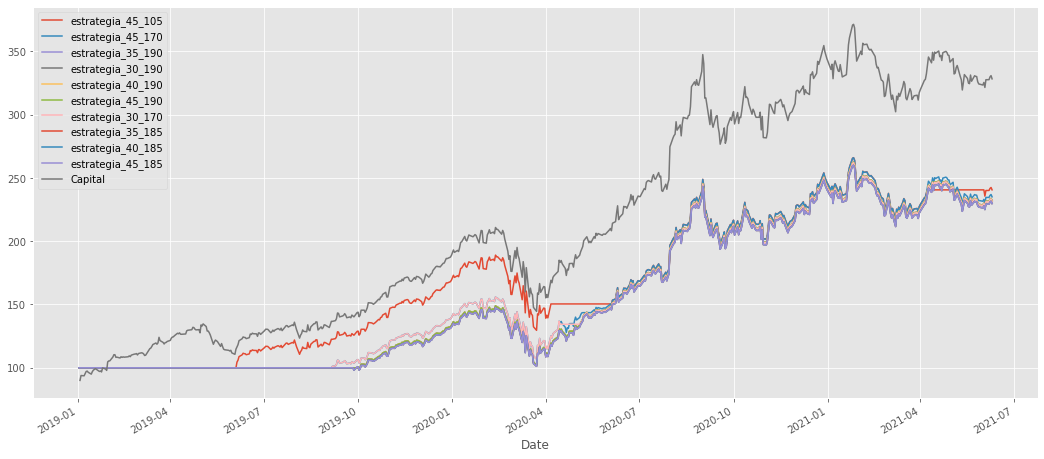

In [631]:
mejores_estrategias=list(resultados_dataframe.iloc[:10].index) # selecciono las mejores 10 estrategias para graficar. 
mejores_estrategias.append('Capital') # Agregamos la estrategia Buy and Hold
capitales[mejores_estrategias].plot()

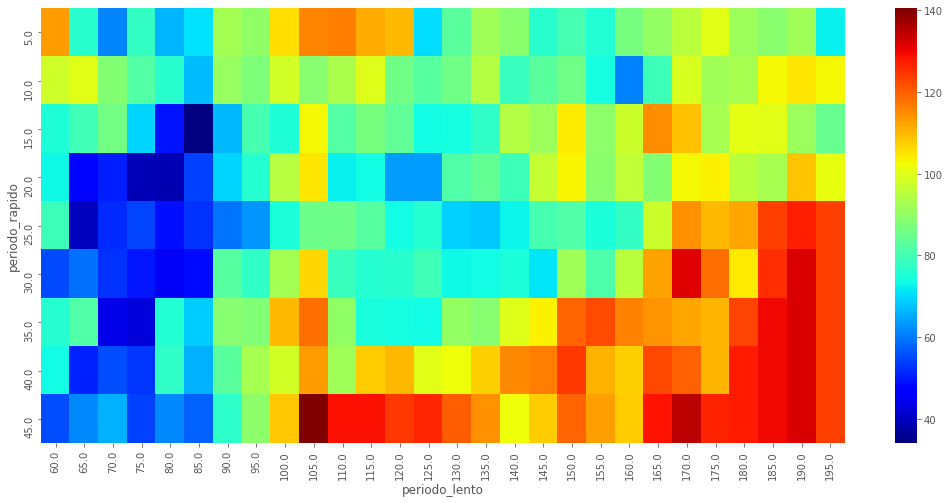

In [632]:
import seaborn as sns
ax=sns.heatmap(resultados_dataframe.pivot('periodo_rapido','periodo_lento','Beneficio Bruto'), annot=False, cmap=plt.cm.jet )